In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [10]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 13ms/step - loss: 194.6263 - mae: 195.1263
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 195.2579 - mae: 195.7579
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 193.9793 - mae: 194.4793
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 192.3058 - mae: 192.8058
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 189.4673 - mae: 189.9673
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 187.5113 - mae: 188.0113
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 185.2976 - mae: 185.7976
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 183.4113 - mae: 183.9113
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 180.7795 - mae: 181.2795
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - loss: 176.5625 - mae: 177.0625
Epoch 11/100
8/8 [================

8/8 [==============================] - 0s 9ms/step - loss: 25.6902 - mae: 26.1870
Epoch 88/100
8/8 [==============================] - 0s 8ms/step - loss: 23.3355 - mae: 23.8334
Epoch 89/100
8/8 [==============================] - 0s 8ms/step - loss: 26.9875 - mae: 27.4848
Epoch 90/100
8/8 [==============================] - 0s 10ms/step - loss: 21.2730 - mae: 21.7690
Epoch 91/100
8/8 [==============================] - 0s 10ms/step - loss: 35.5544 - mae: 36.0533
Epoch 92/100
8/8 [==============================] - 0s 8ms/step - loss: 20.2964 - mae: 20.7932
Epoch 93/100
8/8 [==============================] - 0s 8ms/step - loss: 36.8600 - mae: 37.3547
Epoch 94/100
8/8 [==============================] - 0s 8ms/step - loss: 51.3326 - mae: 51.8312
Epoch 95/100
8/8 [==============================] - 0s 22ms/step - loss: 23.2654 - mae: 23.7596
Epoch 96/100
8/8 [==============================] - 0s 9ms/step - loss: 27.9033 - mae: 28.3979
Epoch 97/100
8/8 [==============================] - 0s 9ms/s

(1e-08, 0.0001, 0.0, 30.0)

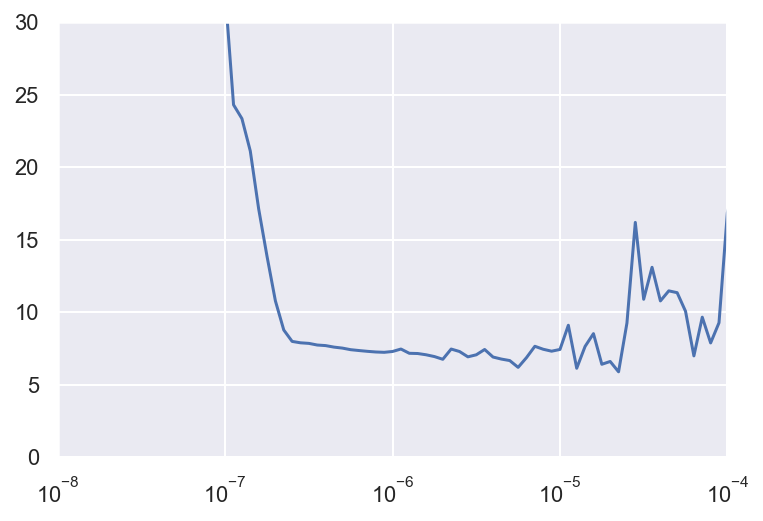

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 12ms/step - loss: 114.4029 - mae: 114.9028
Epoch 2/400
8/8 [==============================] - 0s 14ms/step - loss: 22.2724 - mae: 22.7647
Epoch 3/400
8/8 [==============================] - 0s 13ms/step - loss: 17.3884 - mae: 17.8837
Epoch 4/400
8/8 [==============================] - 0s 15ms/step - loss: 13.2057 - mae: 13.7010
Epoch 5/400
8/8 [==============================] - 0s 14ms/step - loss: 9.7373 - mae: 10.2267
Epoch 6/400
8/8 [==============================] - 0s 10ms/step - loss: 15.2827 - mae: 15.7770
Epoch 7/400
8/8 [==============================] - 0s 10ms/step - loss: 14.7301 - mae: 15.2215
Epoch 8/400
8/8 [==============================] - 0s 9ms/step - loss: 10.9825 - mae: 11.4765
Epoch 9/400
8/8 [==============================] - 0s 14ms/step - loss: 9.8874 - mae: 10.3773
Epoch 10/400
8/8 [==============================] - 0s 16ms/step - loss: 9.6794 - mae: 10.1650
Epoch 11/400
8/8 [==============================] -

Epoch 88/400
8/8 [==============================] - 0s 7ms/step - loss: 4.9715 - mae: 5.4530
Epoch 89/400
8/8 [==============================] - 0s 7ms/step - loss: 4.5683 - mae: 5.0466
Epoch 90/400
8/8 [==============================] - 0s 8ms/step - loss: 4.5633 - mae: 5.0398
Epoch 91/400
8/8 [==============================] - 0s 7ms/step - loss: 4.9314 - mae: 5.4116
Epoch 92/400
8/8 [==============================] - 0s 7ms/step - loss: 5.9168 - mae: 6.3993
Epoch 93/400
8/8 [==============================] - 0s 9ms/step - loss: 5.3096 - mae: 5.7894
Epoch 94/400
8/8 [==============================] - 0s 7ms/step - loss: 5.3976 - mae: 5.8817
Epoch 95/400
8/8 [==============================] - 0s 8ms/step - loss: 5.5389 - mae: 6.0187
Epoch 96/400
8/8 [==============================] - 0s 8ms/step - loss: 7.1834 - mae: 7.6689
Epoch 97/400
8/8 [==============================] - 0s 7ms/step - loss: 7.5729 - mae: 8.0580
Epoch 98/400
8/8 [==============================] - 0s 7ms/step - loss

8/8 [==============================] - 0s 8ms/step - loss: 4.9355 - mae: 5.4120
Epoch 176/400
8/8 [==============================] - 0s 7ms/step - loss: 4.9110 - mae: 5.3913
Epoch 177/400
8/8 [==============================] - 0s 8ms/step - loss: 5.1730 - mae: 5.6527
Epoch 178/400
8/8 [==============================] - 0s 8ms/step - loss: 4.7682 - mae: 5.2469
Epoch 179/400
8/8 [==============================] - 0s 8ms/step - loss: 5.9095 - mae: 6.3952
Epoch 180/400
8/8 [==============================] - 0s 8ms/step - loss: 5.1306 - mae: 5.6065
Epoch 181/400
8/8 [==============================] - 0s 8ms/step - loss: 4.4350 - mae: 4.9157
Epoch 182/400
8/8 [==============================] - 0s 9ms/step - loss: 4.3701 - mae: 4.8500
Epoch 183/400
8/8 [==============================] - 0s 9ms/step - loss: 4.7562 - mae: 5.2347
Epoch 184/400
8/8 [==============================] - 0s 7ms/step - loss: 7.2562 - mae: 7.7411
Epoch 185/400
8/8 [==============================] - 0s 8ms/step - loss: 5

8/8 [==============================] - 0s 8ms/step - loss: 4.5855 - mae: 5.0629
Epoch 263/400
8/8 [==============================] - 0s 13ms/step - loss: 4.8210 - mae: 5.2948
Epoch 264/400
8/8 [==============================] - 0s 23ms/step - loss: 4.6531 - mae: 5.1238
Epoch 265/400
8/8 [==============================] - 0s 9ms/step - loss: 5.5741 - mae: 6.0567
Epoch 266/400
8/8 [==============================] - 0s 9ms/step - loss: 4.7429 - mae: 5.2217
Epoch 267/400
8/8 [==============================] - 0s 10ms/step - loss: 4.7532 - mae: 5.2288
Epoch 268/400
8/8 [==============================] - 0s 7ms/step - loss: 4.6294 - mae: 5.1099
Epoch 269/400
8/8 [==============================] - 0s 8ms/step - loss: 4.5427 - mae: 5.0176
Epoch 270/400
8/8 [==============================] - 0s 9ms/step - loss: 4.5642 - mae: 5.0426
Epoch 271/400
8/8 [==============================] - 0s 7ms/step - loss: 4.6340 - mae: 5.1100
Epoch 272/400
8/8 [==============================] - 0s 8ms/step - loss

8/8 [==============================] - 0s 7ms/step - loss: 4.2155 - mae: 4.6880
Epoch 350/400
8/8 [==============================] - 0s 8ms/step - loss: 4.5080 - mae: 4.9869
Epoch 351/400
8/8 [==============================] - 0s 8ms/step - loss: 4.7167 - mae: 5.1940
Epoch 352/400
8/8 [==============================] - 0s 8ms/step - loss: 5.2308 - mae: 5.7123
Epoch 353/400
8/8 [==============================] - 0s 9ms/step - loss: 5.1964 - mae: 5.6762
Epoch 354/400
8/8 [==============================] - 0s 8ms/step - loss: 5.0385 - mae: 5.5100
Epoch 355/400
8/8 [==============================] - 0s 7ms/step - loss: 4.3507 - mae: 4.8280
Epoch 356/400
8/8 [==============================] - 0s 8ms/step - loss: 4.3003 - mae: 4.7757
Epoch 357/400
8/8 [==============================] - 0s 7ms/step - loss: 5.0487 - mae: 5.5240
Epoch 358/400
8/8 [==============================] - 0s 8ms/step - loss: 4.9412 - mae: 5.4249
Epoch 359/400
8/8 [==============================] - 0s 8ms/step - loss: 5

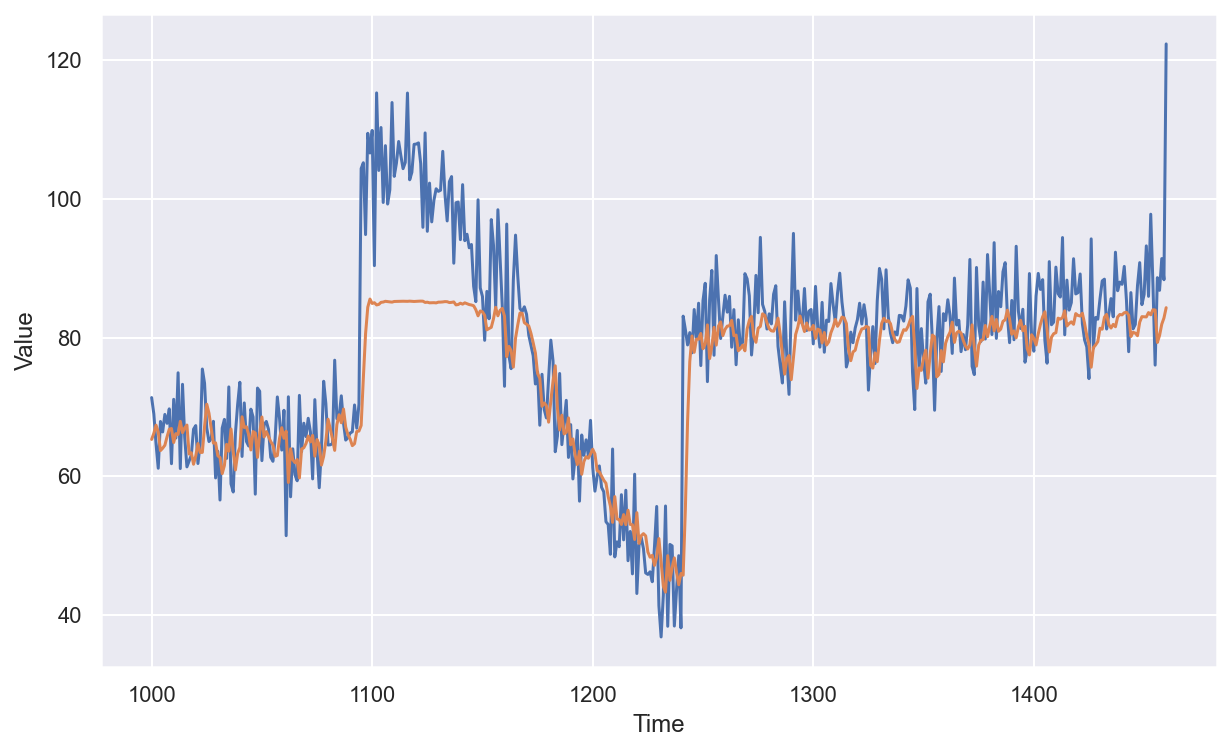

In [16]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.4563427

<Figure size 432x288 with 0 Axes>

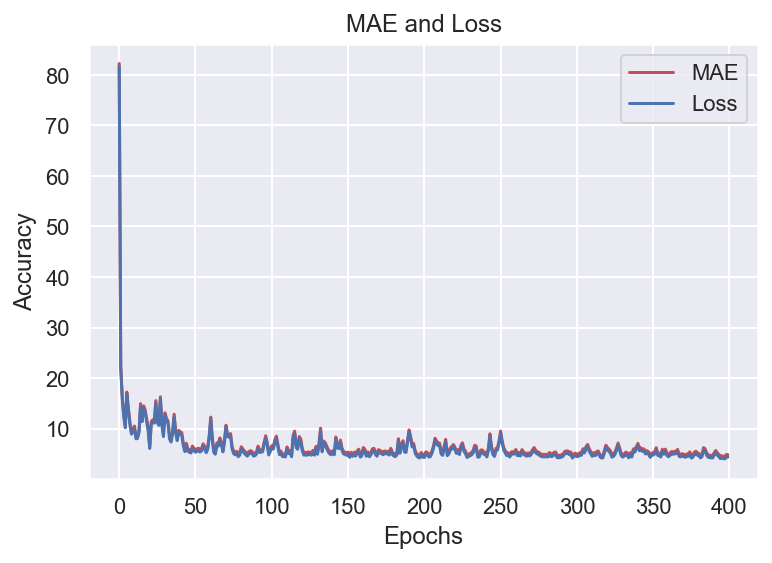

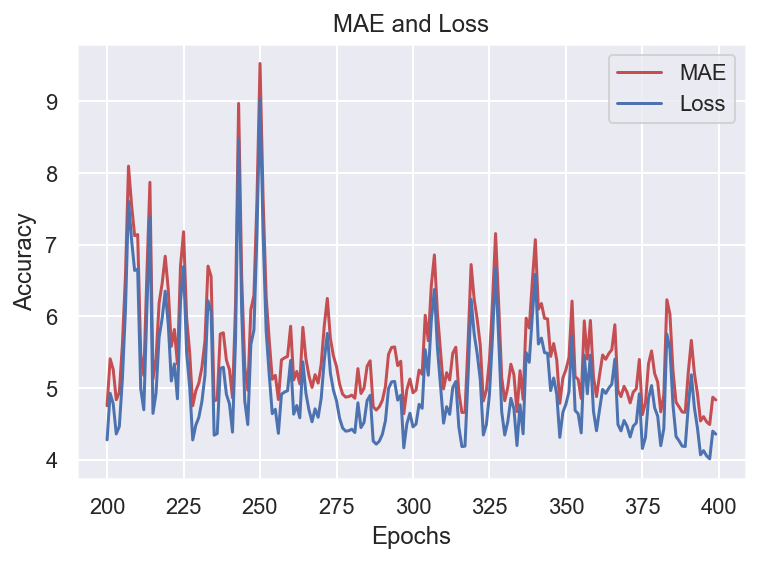

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()